## Homework

In [38]:
# libraries import
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from termcolor import colored
import seaborn as sns
import quadratic_equation as qef

# generate data for training and validation
nPoints = 10000
x_train = qef.quadraticEqGenerator(nPoints)
# only the ones that have the solution
y_train_existence = np.all(~np.isnan(qef.quadraticEqSolution(x_train)), axis=1)
x_train = x_train[y_train_existence]
y_train = qef.quadraticEqSolution(x_train)

nPointsval = 10000
x_val = qef.quadraticEqGenerator(nPointsval)
y_val_existence = np.all(~np.isnan(qef.quadraticEqSolution(x_val)), axis=1)
x_val = x_val[y_val_existence]
y_val = qef.quadraticEqSolution(x_val)

print(colored("Training data shapes: ", "blue"), x_train.shape, y_train.shape)
print(colored("Validation data shapes: ", "blue"), x_val.shape, y_val.shape)

Training data shapes:  (6249, 3) (6249, 2)
Validation data shapes:  (6261, 3) (6261, 2)


Model: "QuadraticSolution"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 3)]               0         
                                                                 
 layer_0 (Dense)             (None, 128)               512       
                                                                 
 dropout_layer_0 (Dropout)   (None, 128)               0         
                                                                 
 layer_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_layer_1 (Dropout)   (None, 256)               0         
                                                                 
 layer_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_layer_2 (Dropout)   (None, 128)         

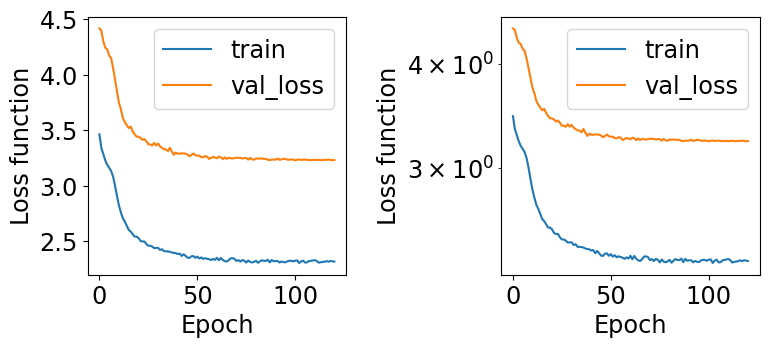

In [43]:
# def getModel, change relu -> swish 
def getModel(inputShape, nNeurons, lr, hiddenActivation='swish', outputActivation='linear', outputNeurons=2, 
             metrics=['MeanAbsoluteError'], kernel_regularizer=None, dropout_rate=0.2):
    inputs = tf.keras.Input(shape=(inputShape,), name="features")
    x = inputs
    
    for iLayer, n in enumerate(nNeurons):
        x = tf.keras.layers.Dense(n, activation=hiddenActivation, 
                                  kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05),
                                  bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                  kernel_regularizer=kernel_regularizer,
                                  name="layer_"+str(iLayer))(x)
        x = tf.keras.layers.Dropout(name="dropout_layer_"+str(iLayer), rate=dropout_rate)(x)
            
    outputs = tf.keras.layers.Dense(outputNeurons, activation=outputActivation, name="output")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QuadraticSolution")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=metrics)
    return model

def quadraticEqMLSolver(x_train, y_train, x_val, y_val, epochs=50):
    # model parameters
    InputShape = 3  # a, b, c
    nNeurons = np.array([128, 256, 128])  
    initial_learning_rate = 0.001
    
    # add L2 weights regularisation
    kernel_regularizer = tf.keras.regularizers.l2(1e-4)
    # add learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=200,
        decay_rate=0.95,
        staircase=True)
    # get model
    model = getModel(InputShape, nNeurons, lr_schedule, 
                     kernel_regularizer=kernel_regularizer, 
                     dropout_rate=0.2, outputNeurons=2)
    model.summary()
    
    # adad early stopping callbcak
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    # do training
    history = model.fit(
        x_train, y_train, 
        epochs=epochs, 
        batch_size=32,  
        validation_data=(x_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    plf.plotTrainHistory(history)
    return model

model = quadraticEqMLSolver(x_train, y_train, x_val, y_val, epochs=500)


196/196 [==============================] - 1s 4ms/step
x-metric (fraction of cases with δ < 10^-2): 0.8640792205717936


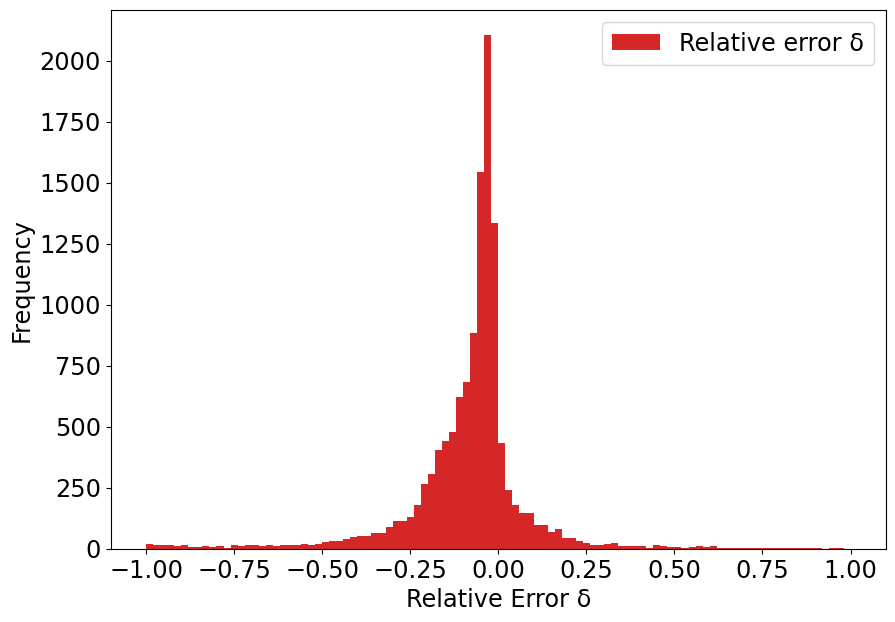

x-metric: 0.0563
fraction of cases for δ < 0.1: 0.6151
fraction of cases for δ < 0.01: 0.0563
fraction of cases for δ < 0.001: 0.0046
fraction of cases for δ < 0.0001: 0.0006
correlation between real and expected values: 0.05


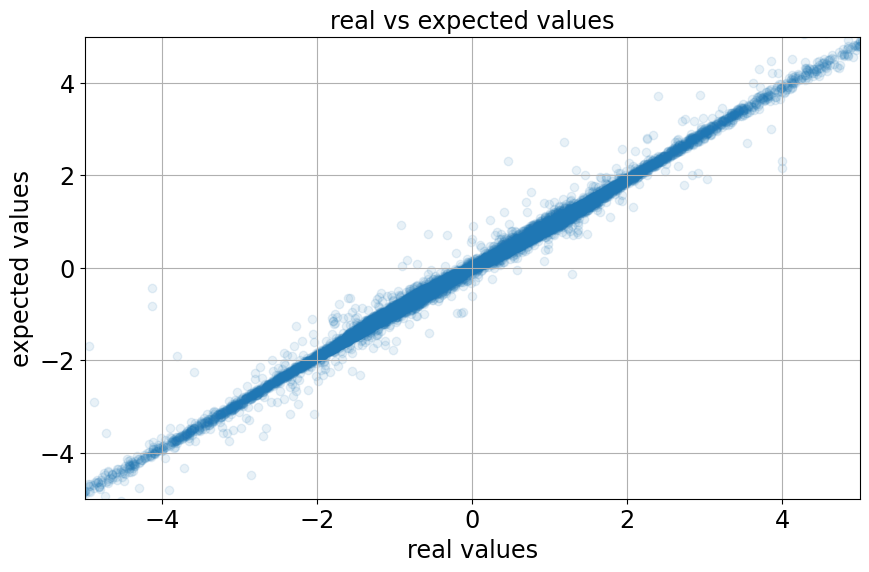

In [44]:

# model evaluation, find delta
def evaluate_model_accuracy(model, x_val, y_val):

    y_pred = model.predict(x_val)
    # find relative error delta = (model - true) / true
    delta = (y_pred - y_val) / y_val

    x_metric = np.mean(delta < 1e-2)
    print("x-metric (fraction of cases with δ < 10^-2): "+str(x_metric))


    plt.hist(delta.flatten(), bins=100, color='tab:red', label='Relative error δ', range=(-1, 1))
    plt.xlabel("Relative Error δ")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    delta = np.abs(delta)
    
    # find the metric x = fraction of cases for which δ < 10^-2
    threshold = 1e-2
    x_metric = np.mean(delta < threshold)
    print(colored(f"x-metric: {x_metric:.4f}", "red"))
    
    # additional metric check
    thresholds = [1e-1, 1e-2, 1e-3, 1e-4]
    for thresh in thresholds:
        accuracy = np.mean(delta < thresh)
        print(f"fraction of cases for δ < {thresh}: {accuracy:.4f}")
    
    # correlation analysis
    correlation = np.corrcoef(y_val.flatten(), y_pred.flatten())[0, 1]
    print(colored(f"correlation between real and expected values: {correlation:.2f}", "blue"))
    
    # plot correlation
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val.flatten(), y_pred.flatten(), alpha=0.1)
    plt.title('real vs expected values')
    plt.xlabel('real values')
    plt.ylabel('expected values')
    plt.grid(True)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.show()

evaluate_model_accuracy(model, x_val, y_val)
